<a href="https://colab.research.google.com/github/johanhoffman/DD2363_VT21/blob/main/template-report-Poisson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The Heat equation**


**Johan Hoffman**

# **Abstract**

This short report show an example on how to use FEniCS to solve the Heat equation, which is used in the course DD2363 Methods in Scientific Computing, at the KTH Royal Institute of Technology.

# **About the code**

In [ ]:
"""This program is an example file for the course"""
"""DD2363 Methods in Scientific Computing, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2021 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2363 Methods in Scientific Computing
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [ ]:
# Load neccessary modules.
# After the first time you run this cell you must "Restart runtime" once, then run the cell again.
from google.colab import files

import numpy as np
import time

try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common 
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *
    
import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

# **Introduction**

The Heat equation takes the form

$\dot u -\Delta u = f,$

together with suitable initial and boundary conditions.

Here we present a FEniCS implementation of a semi-discretization of the 2D Heat equation with a finite element method in space and a trapezoidal time stepping method. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

We seek a finite element approximation $u\in V$ such that 

$(\dot u, v) + (\nabla u,\nabla v) = (f,v),$

for all test functions $v \in V$. 

# **Method**

**Define domain and mesh**

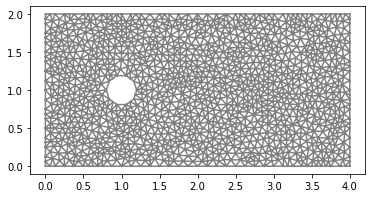

In [ ]:
# Define rectangular domain 
L = 4
H = 2

# Define circle
xc = 1.0
yc = 0.5*H
rc = 0.2

# Define subdomains (for boundary conditions)
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0) 

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], L)

class Lower(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)

class Upper(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], H)
      
left = Left()
right = Right()
lower = Lower()
upper = Upper()

# Generate mesh (examples with and without a hole in the mesh) 
resolution = 32
#mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), L*resolution, H*resolution)
mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(xc,yc),rc), resolution)

# Local mesh refinement (specified by a cell marker)
no_levels = 0
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(xc, yc)) < 1.0:
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

# Define mesh functions (for boundary conditions)
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundaries.set_all(0)
left.mark(boundaries, 1)
right.mark(boundaries, 2)
lower.mark(boundaries, 3)
upper.mark(boundaries, 4)

plt.figure()
plot(mesh)
plt.show()

**Define finite element approximation spaces**

In [ ]:
# Generate finite element space
V = FunctionSpace(mesh, "Lagrange", 1)

# Define trial and test functions 
u = TrialFunction(V)
v = TestFunction(V)

**Define boundary conditions**

In [ ]:
# Define boundary conditions 
class DirichletBoundaryLower(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 0.0)

class DirichletBoundaryUpper(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], H)

class DirichletBoundaryLeft(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.0) 

class DirichletBoundaryRight(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], L)

class DirichletBoundaryObjects(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (not near(x[0], 0.0)) and (not near(x[0], L)) and (not near(x[1], 0.0)) and (not near(x[1], H))

dbc_lower = DirichletBoundaryLower()
dbc_upper = DirichletBoundaryUpper()
dbc_left = DirichletBoundaryLeft()
dbc_right = DirichletBoundaryRight()
dbc_objects = DirichletBoundaryObjects()

# Dirichlet boundary conditions
bcu_left = DirichletBC(V, 0.0, dbc_left)
bcu_right = DirichletBC(V, 0.0, dbc_right)
bcu_upp = DirichletBC(V, 0.0, dbc_upper)
bcu_low = DirichletBC(V, 0.0, dbc_lower)
bcu_obj = DirichletBC(V, 1.0, dbc_objects)

bcu = [bcu_left, bcu_right, bcu_upp, bcu_low, bcu_obj]
#bcu = [bcu_left, bcu_upp, bcu_obj]

# Define measure for boundary integration  
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

# **Results**

**Define parameters**

In [ ]:
# Set heat diffusivity
alpha = 1.0

f = Expression('a*exp(-((x[0]-xf)*(x[0]-xf)+(x[1]-yf)*(x[1]-yf))/b)', element = V.ufl_element(), xf=2.0, yf=1.0, a=0.0, b=1.0)
g = Expression('a*exp(-((x[0]-xf)*(x[0]-xf)+(x[1]-yf)*(x[1]-yf))/b)', element = V.ufl_element(), xf=2.0, yf=1.0, a=5.0, b=1.0)

**Define method parameters**

In [ ]:
# u0 - solution from previous time step
u0 = Function(V)
u1 = Function(V)

u0 = interpolate(g,V)

# Set parameters for linear solvers 
prec = "amg" if has_krylov_solver_preconditioner("amg") else "default" 

# Time step length 
dt = mesh.hmin()*mesh.hmin() 

**Define variational problem**

In [ ]:
# Define variational problem

# Stabilization parameters
h = CellDiameter(mesh);

# Mean solution for trapozoidal time stepping
um = 0.5*(u + u0)

# Variational equation on residual form
R = inner((u - u0)/dt, v)*dx + alpha*inner(grad(um), grad(v))*dx - f*v*dx 
au = lhs(R)
Lu = rhs(R)

**Set plotting variables and open export files**

In [ ]:
# Open files to export solution to Paraview
file_u = File("results-Heat/u.pvd")

# Set plot frequency
plot_time = 0
plot_freq = 10

time = np.array(0.0)
time = np.delete(time, 0)
start_sample_time = 1.0

**Time stepping algorithm**

rm: cannot remove 'results-NS/*': No such file or directory
Time t = 0.0043178203110671234


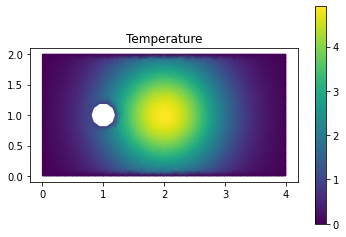

Time t = 0.10362768746561091


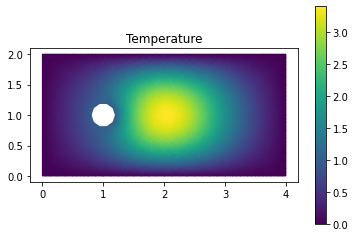

Time t = 0.2029375546201546


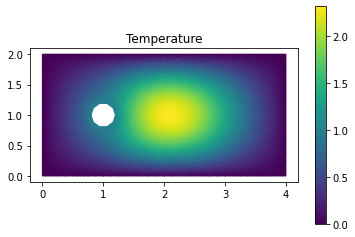

Time t = 0.3022474217746986


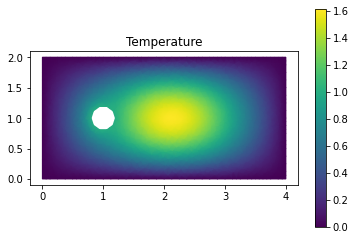

Time t = 0.4015572889292429


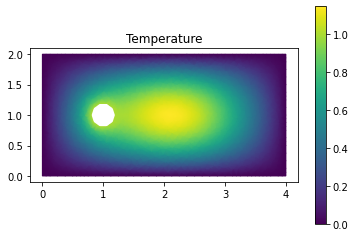

Time t = 0.5008671560837872


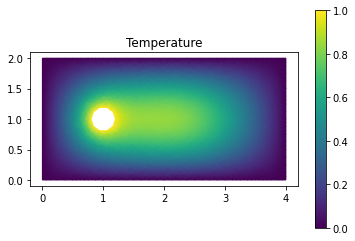

Time t = 0.6001770232383302


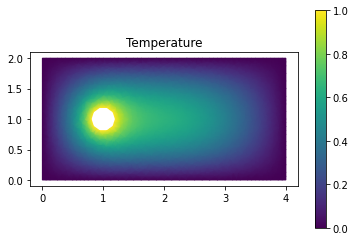

Time t = 0.7038047107039404


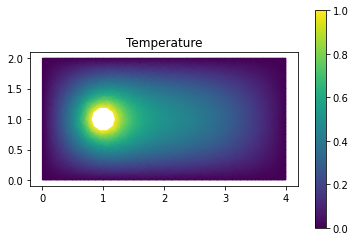

Time t = 0.8031145778584834


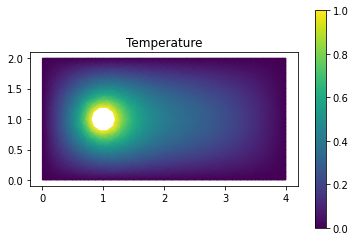

Time t = 0.9024244450130264


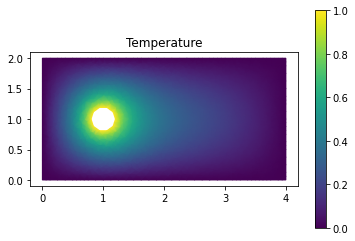

In [ ]:
!rm results-NS/*

# Time stepping 
T = 1
t = dt
while t < T + DOLFIN_EPS:

    #s = 'Time t = ' + repr(t) 
    #print(s)

    # Assemble matrix and vector 
    A = assemble(au)
    b = assemble(Lu)

    # Compute solution 
    [bc.apply(A, b) for bc in bcu]
    [bc.apply(u1.vector()) for bc in bcu]
    solve(A, u1.vector(), b, "bicgstab", "default")

    if t > plot_time:     
        
        s = 'Time t = ' + repr(t) 
        print(s)
    
        # Save solution to file
        file_u << u1

        # Plot solution
        plt.figure()
        p = plot(u1, title="Temperature", mode='color')
        plt.colorbar(p)

        plot_time += T/plot_freq
        
        plt.show()

    # Update time step
    u0.assign(u1)
    t += dt

#!tar -czvf results-Heat.tar.gz results-Heat
#files.download('results-Heat.tar.gz')

# **Discussion**

A stabilized finite element method was implemented in FEniCS to solve the Navier-Stokes equations in 2D. The method was tested for the model problem of flow past a circular obstacle, and for a high enough Reynolds number and sufficient mesh resolution [a von Karman vortex street developed as expected.](https://en.wikipedia.org/wiki/Kármán_vortex_street)